In [36]:
#Install required packages (if not installed)
!pip install pandas seaborn matplotlib scikit-learn sentence-transformers --quiet

In [37]:
#Import libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
df = pd.read_csv("/content/failure_clusters.csv")

In [39]:
df = df[df['cluster'] != -1]
df['error_msg'] = df['error_msg'].fillna('No Error')

In [40]:
print("Loaded dataset:", df.shape)
df.head(5)

Loaded dataset: (1930, 20)


,filename,dut,dut_version,os_version,config,test_case_id,line_number,timestamp,run_date,status,error_msg,suite,raw_line,failure_freq_suite,failure_freq_dut,execution_duration,time_since_last_failure,recent_failure_flag,config_hash,cluster
29,tc_conf_ipv4_ihg_022_20240723-151655.log,cisco,1.0,Linux,ipv4_cisco_2,tc_func_ipv4_ifg_001.tcl,519,2024-07-23 15:17:19.777,2024-07-23,FAIL,Could not GET ftppackets.txt file from FTP ser...,ipv4,15:17:19.777 # TEST CASE FAILED :Could not GET...,36.0,45.0,11,0.000,1,46544359,5
30,tc_conf_ipv4_ihg_022_20240723-151655.log,cisco,1.0,Linux,ipv4_cisco_2,tc_func_ipv4_ifg_001.tcl,636,2024-07-23 15:17:25.163,2024-07-23,FAIL,Could not GET ftppackets.txt file from FTP #,ipv4,15:17:25.163 # Result: FAILED Could not GET f...,36.0,45.0,10,5.386,1,46544359,5
31,tc_conf_ipv4_ihg_022_20240723-152428.log,cisco,1.0,Linux,ipv4_cisco_2,tc_func_ipv4_ifg_001.tcl,522,2024-07-23 15:24:47.317,2024-07-23,FAIL,Could not GET ftppackets.txt file from FTP ser...,ipv4,15:24:47.317 # TEST CASE FAILED :Could not GET...,36.0,45.0,16,442.154,1,46544359,5
32,tc_conf_ipv4_ihg_022_20240723-152428.log,cisco,1.0,Linux,ipv4_cisco_2,tc_func_ipv4_ifg_001.tcl,639,2024-07-23 15:24:52.647,2024-07-23,FAIL,Could not GET ftppackets.txt file from FTP #,ipv4,15:24:52.647 # Result: FAILED Could not GET f...,36.0,45.0,54,5.330,1,46544359,5
42,tc_conf_ipv4_ihg_022_20240724-090903.log,cisco,1.0,Linux,ipv4_cisco_2,tc_func_ipv4_ifg_001.tcl,510,2024-07-24 09:09:20.724,2024-07-24,FAIL,Could not receive Ping reply from H2.,ipv4,09:09:20.724 # TEST CASE FAILED :Could not rec...,36.0,45.0,50,63868.077,1,46544359,5


In [41]:
print("Loaded dataset:", df.shape)
df.tail(5)

Loaded dataset: (1930, 20)


,filename,dut,dut_version,os_version,config,test_case_id,line_number,timestamp,run_date,status,error_msg,suite,raw_line,failure_freq_suite,failure_freq_dut,execution_duration,time_since_last_failure,recent_failure_flag,config_hash,cluster
8597,tc_conf_sip_dtg_001_20250902-175139.log,xlite,1.6,Linux,x_lite,tc_conf_sip_dtg_001,520,2025-09-02 17:52:34.898,2025-09-02,FAIL,Could not verify the SIP INVITE request. #,sip,17:52:34.898 # Result: FAILED Could not verif...,26.0,6.0,20,1.003,1,86850425,5
8599,tc_conf_sip_dtg_001_20250902-175402.log,xlite,1.6,Linux,x_lite,tc_conf_sip_dtg_001,508,2025-09-02 17:56:29.748,2025-09-02,FAIL,Could not verify the SIP INVITE request.,sip,17:56:29.748 # TEST CASE FAILED :Could not ver...,26.0,6.0,19,234.850,1,86850425,5
8600,tc_conf_sip_dtg_001_20250902-175402.log,xlite,1.6,Linux,x_lite,tc_conf_sip_dtg_001,520,2025-09-02 17:56:30.750,2025-09-02,FAIL,Could not verify the SIP INVITE request. #,sip,17:56:30.750 # Result: FAILED Could not verif...,26.0,6.0,60,1.002,1,86850425,5
8603,tc_conf_sip_hvg_001_20250902-180038.log,xlite,1.5,Linux,x_lite,tc_conf_sip_hvg_001,498,2025-09-02 18:01:41.607,2025-09-02,FAIL,DUT has not sent REGISTER request with expecte...,sip,18:01:41.607 # TEST CASE FAILED :DUT has not s...,26.0,6.0,47,0.000,1,86850425,6
8604,tc_conf_sip_hvg_001_20250902-180038.log,xlite,1.5,Linux,x_lite,tc_conf_sip_hvg_001,511,2025-09-02 18:01:42.602,2025-09-02,FAIL,DUT has not sent REGISTER request with expected #,sip,18:01:42.602 # Result: FAILED DUT has not sen...,26.0,6.0,22,0.995,1,86850425,6


In [45]:
#Extract the Keywords
def extract_keywords(df, top_n=5):
    cluster_keywords = {}
    for cid, subset in df.groupby("cluster"):
        words = " ".join(subset["error_msg"].astype(str)).lower().split()
        stop_words = {"the","and","for","to","in","of","on","with","is","a","at","from","by"}
        filtered = [w for w in words if w not in stop_words and len(w) > 2]
        most_common = [w for w, _ in Counter(filtered).most_common(top_n)]
        cluster_keywords[cid] = most_common
    return cluster_keywords

cluster_keywords = extract_keywords(df)
print("Extracted top keywords per cluster:")
cluster_keywords

Extracted top keywords per cluster:


{0: ['does', 'not', 'transmit', 'message', 'port'],
 1: ['error', 'capture', 'does', 'not', 'exist'],
 2: ['failed', 'stopping', 'ptp:', 'cli:', 'ptp'],
 3: ['test', 'result', 'may', 'correct.'],
 4: ['dut', 'does', 'not', 'transmit', 'message'],
 5: ['test', 'case', 'not', 'only', 'marker'],
 6: ['dut', 'not', 'has', 'configured', 'value'],
 7: ['dut', 'not', 'does', 'port', 'message'],
 8: ['dut', 'not', 'announce', 'does', 'port'],
 9: ['command:', 'ptp', 'v2bc', 'v2tc', '256']}

In [46]:
#Assign root cause labels
HUMAN_LABELS = {
    0: "Interface / Port Mismatch",
    1: "Capture / ID Handling Error",
    2: "CLI / Command Execution Failure",
    3: "Test Result / Validation Issue",
    4: "PTP Transmission / PDELAY_RESP Failure",
    5: "Bit / Marker Configuration Error",
    6: "DUT Configuration Value Error",
    7: "DUT Port / State Mismatch",
    8: "Announce / SIP Transmission Error",
    9: "PTP Command / Domain Configuration Error"
}

df['root_cause_label'] = df['cluster'].map(lambda c: HUMAN_LABELS.get(c, "Uncategorized"))
df['keywords'] = df['cluster'].map(lambda c: ", ".join(cluster_keywords.get(c, [])))
df.head(5)

,filename,dut,dut_version,os_version,config,test_case_id,line_number,timestamp,run_date,status,...,raw_line,failure_freq_suite,failure_freq_dut,execution_duration,time_since_last_failure,recent_failure_flag,config_hash,cluster,root_cause_label,keywords
29,tc_conf_ipv4_ihg_022_20240723-151655.log,cisco,1.0,Linux,ipv4_cisco_2,tc_func_ipv4_ifg_001.tcl,519,2024-07-23 15:17:19.777,2024-07-23,FAIL,...,15:17:19.777 # TEST CASE FAILED :Could not GET...,36.0,45.0,11,0.000,1,46544359,5,Bit / Marker Configuration Error,"test, case, not, only, marker"
30,tc_conf_ipv4_ihg_022_20240723-151655.log,cisco,1.0,Linux,ipv4_cisco_2,tc_func_ipv4_ifg_001.tcl,636,2024-07-23 15:17:25.163,2024-07-23,FAIL,...,15:17:25.163 # Result: FAILED Could not GET f...,36.0,45.0,10,5.386,1,46544359,5,Bit / Marker Configuration Error,"test, case, not, only, marker"
31,tc_conf_ipv4_ihg_022_20240723-152428.log,cisco,1.0,Linux,ipv4_cisco_2,tc_func_ipv4_ifg_001.tcl,522,2024-07-23 15:24:47.317,2024-07-23,FAIL,...,15:24:47.317 # TEST CASE FAILED :Could not GET...,36.0,45.0,16,442.154,1,46544359,5,Bit / Marker Configuration Error,"test, case, not, only, marker"
32,tc_conf_ipv4_ihg_022_20240723-152428.log,cisco,1.0,Linux,ipv4_cisco_2,tc_func_ipv4_ifg_001.tcl,639,2024-07-23 15:24:52.647,2024-07-23,FAIL,...,15:24:52.647 # Result: FAILED Could not GET f...,36.0,45.0,54,5.330,1,46544359,5,Bit / Marker Configuration Error,"test, case, not, only, marker"
42,tc_conf_ipv4_ihg_022_20240724-090903.log,cisco,1.0,Linux,ipv4_cisco_2,tc_func_ipv4_ifg_001.tcl,510,2024-07-24 09:09:20.724,2024-07-24,FAIL,...,09:09:20.724 # TEST CASE FAILED :Could not rec...,36.0,45.0,50,63868.077,1,46544359,5,Bit / Marker Configuration Error,"test, case, not, only, marker"


In [47]:
#Representative examples per cluster
examples = []
for cid, subset in df.groupby("cluster"):
    label = subset['root_cause_label'].mode().iat[0]
    example_msgs = subset['error_msg'].head(3).tolist()
    examples.append({
        "cluster": cid,
        "root_cause_label": label,
        "keywords": ", ".join(cluster_keywords.get(cid, [])),
        "example_errors": " | ".join(example_msgs)
    })

examples_df = pd.DataFrame(examples)
examples_df

,cluster,root_cause_label,keywords,example_errors
0,0,Interface / Port Mismatch,"does, not, transmit, message, port",DUT does not transmit PDELAY_RESP message on p...
1,1,Capture / ID Handling Error,"error, capture, does, not, exist",with error - Capture id does not exist | with ...
2,2,CLI / Command Execution Failure,"failed, stopping, ptp:, cli:, ptp",18:06:38.055 # Result: ABORTED DUT PTP port P...
3,3,Test Result / Validation Issue,"test, result, may, correct.",or test result may be in correct. | or test re...
4,4,PTP Transmission / PDELAY_RESP Failure,"dut, does, not, transmit, message",DUT does not transmit PDELAY_RESP message on ...
5,5,Bit / Marker Configuration Error,"test, case, not, only, marker",Could not GET ftppackets.txt file from FTP ser...
6,6,DUT Configuration Value Error,"dut, not, has, configured, value",DUT accepts different Domain Number DN2 sent i...
7,7,DUT Port / State Mismatch,"dut, not, does, port, message",DUT does not transmit DELAY_REQ message on por...
8,8,Announce / SIP Transmission Error,"dut, not, announce, does, port",DUT has not sent the SIP BYE Request to TEE. |...
9,9,PTP Command / Domain Configuration Error,"command:, ptp, v2bc, v2tc, 256",to the remote host. | to the remote host. | to...


/tmp/ipython-input-1816996057.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='root_cause_label', data=df, order=df['root_cause_label'].value_counts().index, palette='Set2')


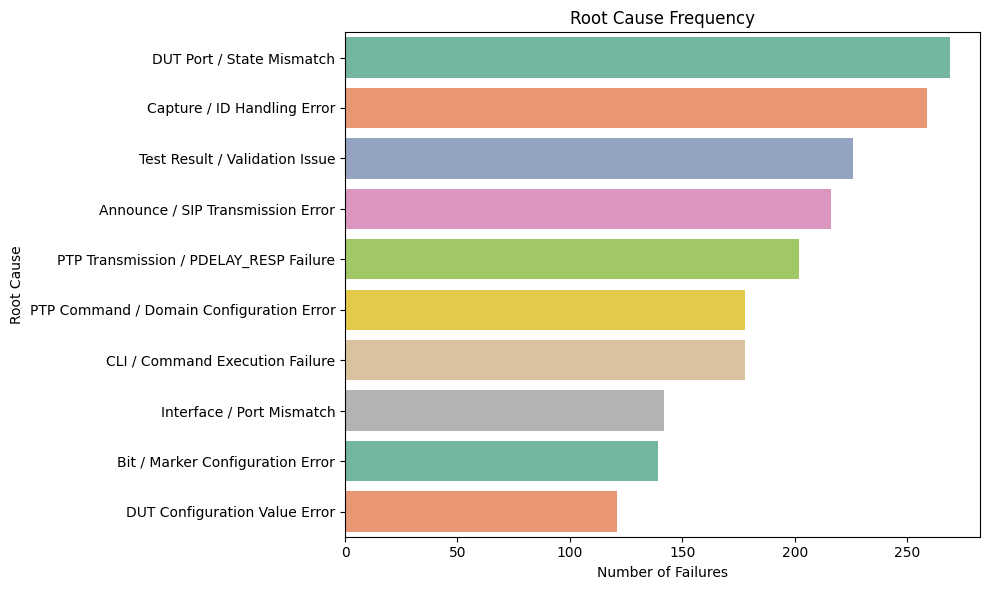

In [48]:
# Root cause frequency
plt.figure(figsize=(10,6))
sns.countplot(y='root_cause_label', data=df, order=df['root_cause_label'].value_counts().index, palette='Set2')
plt.title('Root Cause Frequency')
plt.xlabel('Number of Failures')
plt.ylabel('Root Cause')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1709105534.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df, palette='Set3')


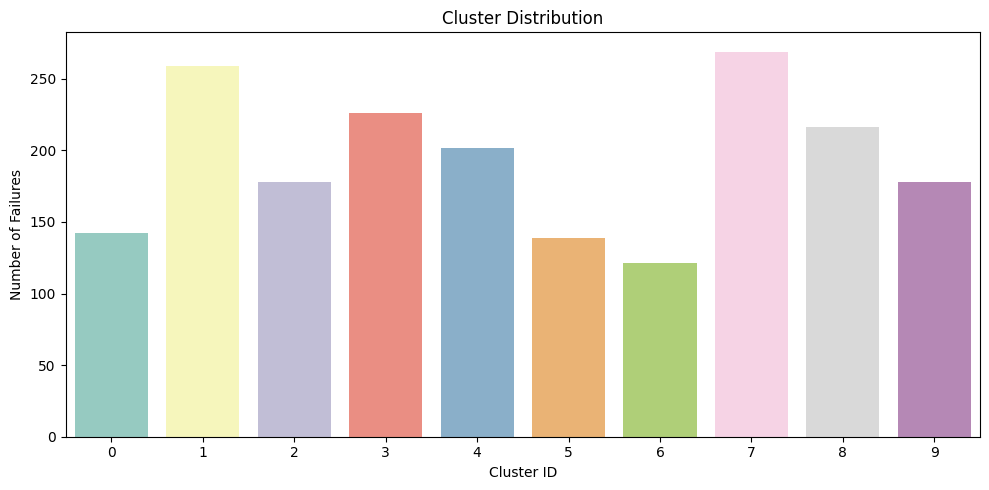

In [49]:
# Cluster distribution
plt.figure(figsize=(10,5))
sns.countplot(x='cluster', data=df, palette='Set3')
plt.title('Cluster Distribution')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Failures')
plt.tight_layout()
plt.show()

In [50]:
# Top N failure clusters failure count
top_n = 5
summary_df = (
    df.groupby(['cluster', 'root_cause_label'])
      .agg(
          failure_count=('error_msg', 'count'),
          keywords=('keywords', lambda x: ", ".join(list(set(", ".join(x).split(", ")))[:6]))
      )
      .reset_index()
      .sort_values(by='failure_count', ascending=False)
      .head(top_n)
)

print(f"Top {top_n} Failure Clusters:")
display(summary_df)

Top 5 Failure Clusters:


,cluster,root_cause_label,failure_count,keywords
7,7,DUT Port / State Mismatch,269,"not, does, dut, port, message"
1,1,Capture / ID Handling Error,259,"not, does, capture, exist, error"
3,3,Test Result / Validation Issue,226,"correct., result, may, test"
8,8,Announce / SIP Transmission Error,216,"not, does, announce, dut, port"
4,4,PTP Transmission / PDELAY_RESP Failure,202,"not, does, dut, transmit, message"


/tmp/ipython-input-935649633.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


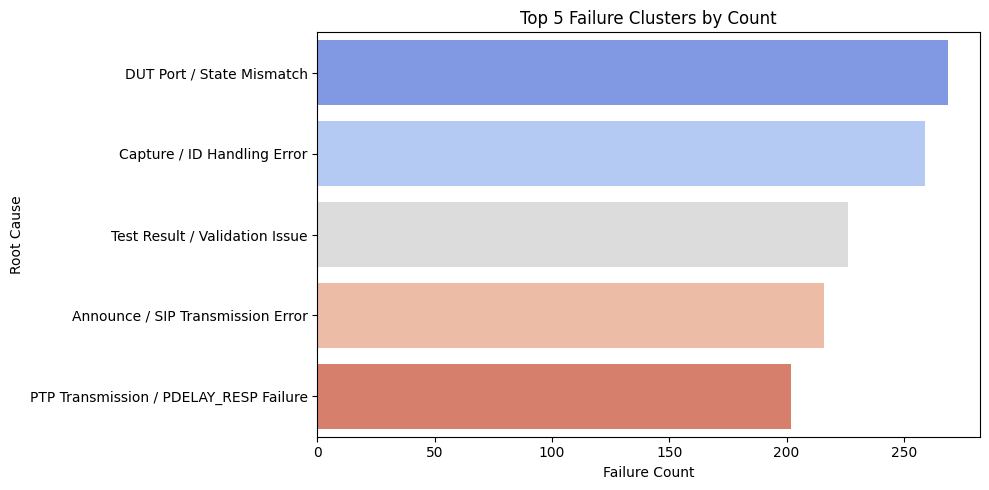

In [51]:
#visualize Top N clusters
plt.figure(figsize=(10,5))
sns.barplot(
    data=summary_df,
    x='failure_count',
    y='root_cause_label',
    palette='coolwarm'
)
plt.title(f"Top {top_n} Failure Clusters by Count")
plt.xlabel('Failure Count')
plt.ylabel('Root Cause')
plt.tight_layout()
plt.show()

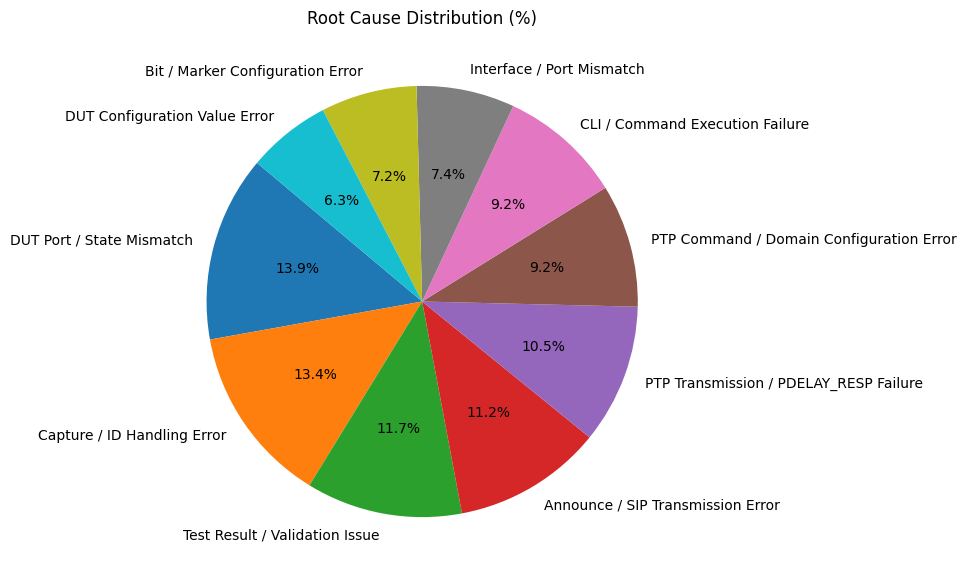

In [52]:
plt.figure(figsize=(7,7))
root_counts = df['root_cause_label'].value_counts()
plt.pie(root_counts, labels=root_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Root Cause Distribution (%)')
plt.show()